# LandLab Learning

This notebook is for investigating and getting used to the LandLab Python package for hydrology modelling.

I will broadly follow the guide on https://landlab.readthedocs.io/en/latest/user_guide

In [1]:
import numpy as np
import landlab as ldlb
import matplotlib.pyplot as plt

## Set up a model grid

... and add an idealised quadratic elevation profile to it, mimicking a valley.

In [2]:
from landlab import RasterModelGrid

In [15]:
#set up 40x40 grid
mg = RasterModelGrid((102, 102), 5.)

#let's try to add an idealised elevation profile to this grid.
valley = np.zeros((102,102))

def valleyfunc(x, y):
    e = (x-51)**2 + y
    return e

for x in np.arange(0, 102, 1):
    for y in np.arange(0, 102, 1):
        valley[y][x] = valleyfunc(x,y)

mg.add_field("elevation", valley, at="node", units="m", copy=True, clobber=True)

array([ 2601.,  2500.,  2401., ...,  2405.,  2502.,  2601.])

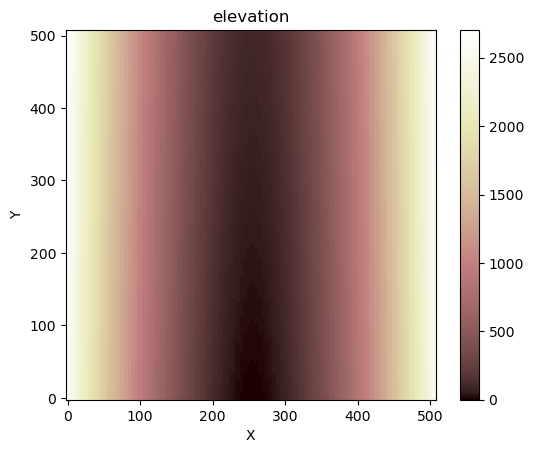

In [16]:
from landlab.plot.imshow import imshow_grid_at_node
#N.B. the Landlab user guide tells you to import the wrong component here

plt.figure('Elevations from the field')  # new fig, with a name
imshow_grid_at_node(mg, 'elevation')
plt.show()

We can also add some vegetation:

In [17]:
veg = mg.add_ones("percent_vegetation", at="cell")

Note that the vegetation is set up at the 'cell' level, while the elevation is set at the 'node' level. Nodes are the cell centres (meaning there is a well-defined way to calculate gradients between values at nodes of neighbouring cells), while 'cell' data lives uniformly across the entire volume of the cell. On a grid, there are fewer cells than nodes: the boundary rows do not count as cells.

For us, this probably means we want our Landlab grid to be two nodes larger in $x$ and $y$ than our NetLogo grid: This means they have the same number of cells, but the Landlab grid also has an additional rim of nodes around the outside that we can set boundary conditions on.

I now want to start trying to reproduce some of what Zhou et al. (2013) did - this means trying to match the Landlab components they added to the description in the paper and accompanying Jupyter notebook.

First, we import the required modules:
 - Vegetation: Model plant dynamics using multiple representative plant species. Landlab component that simulates net primary productivity, biomass and leaf area index at each cell based on inputs of root-zone average soil moisture. https://landlab.readthedocs.io/en/latest/reference/components/vegetation_dynamics.html
 - SoilMoisture: Compute the decay of soil moisture saturation at storm-interstorm time period. Landlab component that simulates root-zone average soil moisture at each cell using inputs of potential evapotranspiration, live leaf area index, and vegetation cover. https://landlab.readthedocs.io/en/latest/reference/components/soil_moisture.html
 - Radiation: Calculate solar radiation on topography given latitude, date, and time. Landlab component that computes 1D and 2D total incident shortwave radiation. This code also computes relative incidence shortwave radiation compared to a flat surface. https://landlab.readthedocs.io/en/latest/reference/components/radiation.html
 - PotentialEvapotranspiration: Compute potential evapotranspiration. Component calculates spatially distributed potential evapotranspiration based on input radiation factor (spatial distribution of incoming radiation) using chosen method such as constant or Priestley Taylor. https://landlab.readthedocs.io/en/latest/reference/components/pet.html#landlab.components.pet.potential_evapotranspiration_field.PotentialEvapotranspiration
 - PrecipitationDistribution: Generate random sequence of precipitation events. This component can generate a random storm duration, interstorm duration, precipitation intensity or storm depth from a Poisson distribution when given a mean value. https://landlab.readthedocs.io/en/latest/reference/components/uniform_precip.html . I don't know if we want to use this component for our model - it seems most suited to climates where precipitation occurs mostly in intense storms that are few and far between - i.e., dry savanna. This is likely not the case for the area we are trying to model, where I expect we have rainfall quite frequently outside the Canicula dry period.
 

In [18]:
from landlab.components import Vegetation
from landlab.components import SoilMoisture
from landlab.components import Radiation
from landlab.components import PotentialEvapotranspiration
from landlab.components import PrecipitationDistribution

Our mission statement: Receive land cover input, give soil moisture/biomass growth output

For our initial toy model, let's use what's already there and make use of the PrecipitationDistribution component to generate our rainfall time series, and make our time step based on that.

First, we make a configuration file to specify a few key variables.

In [21]:
config = {
    'canicula_start':182,
    'canicula_end':223, #assume Canicula starts on 1st of July and lasts for 40 days
    'mean_interstorm_wet':5,
    'mean_storm_wet':2,
    'mean_interstorm_dry':20,
    'mean_storm_dry':2
}

In [20]:
# # Represent current time in years
current_time = 0  # Start from first day of Jan

# declaring few variables that will be used in the storm loop
time_check = 0.0  # Buffer to store current_time at previous storm
yrs = 0  # Keep track of number of years passed
WS = 0.0  # Buffer for Water Stress
Tg = 270  # Growing season in days


Calculate number of time steps based on rainfall likelihood and duration as well as desired length of simulation in years

In [23]:
31*270/360

23.25

In [ ]:
n_years = 50  # Approx number of years for model to run
# Calculate approximate number of storms per year
fraction_dry = (223 - 182) / 365.0 #assume Canicula starts on 1st of July and lasts for 40 days
fraction_wet = 1 - fraction_dry
no_of_storms_wet = (
    8760 * (fraction_wet) / (config["mean_interstorm_wet"] + config["mean_storm_wet"])
)
no_of_storms_dry = (
    8760 * (fraction_dry) / (config["mean_interstorm_dry"] + config["mean_storm_dry"])
)
n = int(n_years * (no_of_storms_wet + no_of_storms_dry))

In [ ]:
#initialise timeseries 

PD_D = np.zeros(40) #empty array for dry season (Canicula) rainfall
PD_W = np.zeros(325) #empty array for wet season rainfall
P = 


In [ ]:
# # Run storm Loop
for i in range(0, n):
    # Update objects

    # Calculate Day of Year (DOY)
    Julian = int(np.floor((current_time - np.floor(current_time)) * 365.0))

    # Generate seasonal storms
    # for Dry season
    if Julian < 223 or Julian > 182: #assume Canicula starts on 1st of July and lasts for 40 days
        PD_D.update()
        P[i] = PD_D.storm_depth
        Tr[i] = PD_D.storm_duration
        Tb[i] = PD_D.interstorm_duration
    # Wet Season 
    else:
        PD_W.update()
        P[i] = PD_W.storm_depth
        Tr[i] = PD_W.storm_duration
        Tb[i] = PD_W.interstorm_duration

    # Spatially distribute PET and its 30-day-mean (analogous to degree day)
    grid["cell"]["surface__potential_evapotranspiration_rate"] = PET_[Julian]
    grid["cell"]["surface__potential_evapotranspiration_30day_mean"] = EP30[Julian]

    # Assign spatial rainfall data
    grid["cell"]["rainfall__daily_depth"] = P[i] * np.ones(grid.number_of_cells)

    # Update soil moisture component
    current_time = SM.update(current_time, Tr=Tr[i], Tb=Tb[i])

    # Decide whether its growing season or not
    if Julian != 364:
        if EP30[Julian + 1, 0] > EP30[Julian, 0]:
            PET_threshold = 1
            # 1 corresponds to ETThresholdup (begin growing season)
        else:
            PET_threshold = 0
            # 0 corresponds to ETThresholddown (end growing season)

    # Update vegetation component
    VEG.update(PETThreshold_switch=PET_threshold, Tb=Tb[i], Tr=Tr[i])

    # Update yearly cumulative water stress data
    WS += (grid["cell"]["vegetation__water_stress"]) * Tb[i] / 24.0

    # Record time (optional)
    Time[i] = current_time

    # Update spatial PFTs with Cellular Automata rules
    if (current_time - time_check) >= 1.0:
        if yrs % 100 == 0:
            print(f"Elapsed time = {yrs} years")
        VegType[yrs] = grid1["cell"]["vegetation__plant_functional_type"]
        WS_ = np.choose(VegType[yrs], WS)
        grid1["cell"]["vegetation__cumulative_water_stress"] = WS_ / Tg
        vegca.update()
        time_check = current_time
        WS = 0
        yrs += 1

VegType[yrs] = grid1["cell"]["vegetation__plant_functional_type"]